# MTG card Data Collection and EDA

In this Code we will scrape, clean, and preform EDA on Magic the Gathering data from an API

## Loading Packages

In [129]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import time

## Load Data

In [130]:
base_url = "https://api.magicthegathering.io/v1/cards"
endpoint = "?set=LTR"
url = base_url + endpoint

In [131]:
all_cards = []
page = 1

#Loop though all pages of cards
while True:
    response = requests.get(url, params={"page": page})
    data = response.json().get("cards", [])
    
    if not data:  # Stop when no cards are returned
        break
    
    #add cards to list
    all_cards.extend(data)

    #Output for number of pages
    print(f"Fetched page {page} with {len(data)} cards")
    page += 1

    #Sleep time for good API etiquette
    time.sleep(1)


Fetched page 1 with 100 cards
Fetched page 2 with 100 cards
Fetched page 3 with 100 cards
Fetched page 4 with 100 cards
Fetched page 5 with 100 cards
Fetched page 6 with 100 cards
Fetched page 7 with 100 cards
Fetched page 8 with 100 cards
Fetched page 9 with 56 cards


## Clean Data

In [132]:
#Turn data into a data frame
data = pd.json_normalize(all_cards)
print(f"Total cards before cleaning: {len(data)}")

#Select relevent columns
trimmed_data = data[['name', 'manaCost', 'cmc', 'colors', 'colorIdentity', 'types', 
                    'supertypes', 'subtypes', 'rarity',  'power', 
                    'toughness', 'multiverseid']]

#Remove duplicate cards by taking the lowest 'multiverseid' (the original printing of the card)
trimmed_data = trimmed_data[trimmed_data['multiverseid'].notna()]
trimmed_data['multiverseid'] = trimmed_data['multiverseid'].astype(int)
formatted_data = trimmed_data.loc[trimmed_data.groupby('name')['multiverseid'].idxmin()]

#Split mana into generic and colered
formatted_data['mana_generic'] = formatted_data['manaCost'].str.extract(r'(\{[\dX]\})')
formatted_data['mana_generic'] = formatted_data['mana_generic'].str.replace(r'[{}]', "", regex = True)
formatted_data['mana_generic'] = formatted_data['mana_generic'].fillna(0)
formatted_data['mana_colored'] = (formatted_data['manaCost'].str.extractall(r'\{([WUBRG])\}').groupby(level=0)[0].apply(list))
formatted_data['mana_colored'] = formatted_data['mana_colored'].apply(lambda x: x if isinstance(x, list) else ['None'])

#fill NAs with apropriate value
formatted_data['colorIdentity'] = formatted_data['colorIdentity'].fillna('Colorless')
formatted_data['supertypes'] = formatted_data['supertypes'].fillna('None')

print(f"Total cards after cleaning: {len(formatted_data)}")

Total cards before cleaning: 856
Total cards after cleaning: 289


## EDA on Converted Mana Cost

### CMC vs Color Identity

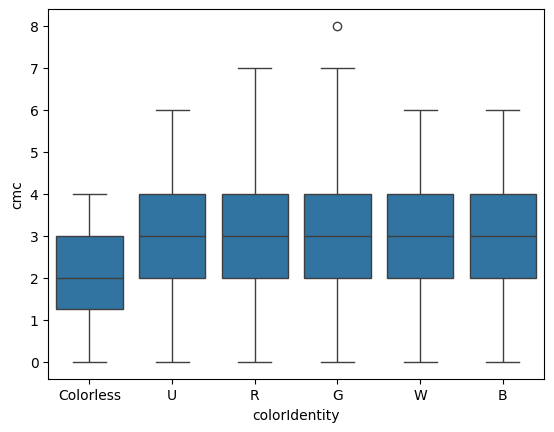

In [133]:
# Copy data frame for plotting
plot_df = formatted_data.copy()

# Keep only rows where colorIdentity is one Color or Colorless
plot_df = plot_df[plot_df['colorIdentity'].apply(lambda x: (isinstance(x, list) and len(x) <= 1) or x == 'Colorless')]

# Convert single-element lists to the element (e.g. ['W'] -> 'W')
plot_df['colorIdentity'] = plot_df['colorIdentity'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Plot Graph
sns.boxplot(data=plot_df, x='colorIdentity', y='cmc')

# Save Graph
plt.savefig('cmc_vs_color_1.png', bbox_inches='tight')
plt.show()

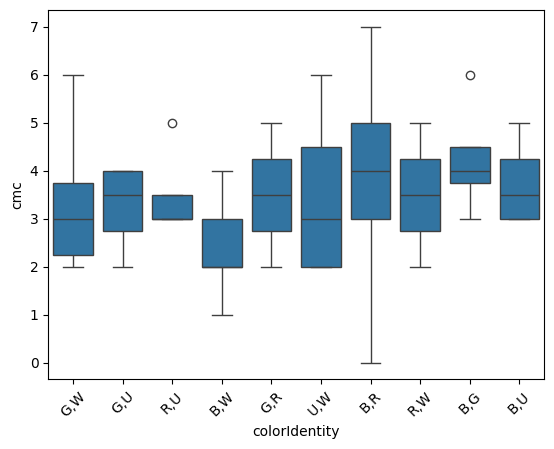

In [134]:
# Copy data frame for plotting
plot_df = formatted_data.copy()

# Keep only rows where colorIdentity has 2 Colors
plot_df = plot_df[plot_df['colorIdentity'].apply(lambda x: isinstance(x, list) and (len(x) > 1 and len(x) < 3))]

# Convert lists to string (e.g. ['G', 'W'] -> 'G,W')
plot_df['colorIdentity'] = plot_df['colorIdentity'].apply(lambda x: ",".join(x) if isinstance(x, list) else str(x))

# Plot graph
sns.boxplot(data=plot_df, x='colorIdentity', y='cmc')
plt.xticks(rotation = 45)

# Save Graph
plt.savefig('cmc_vs_color_2.png', bbox_inches='tight')
plt.show()

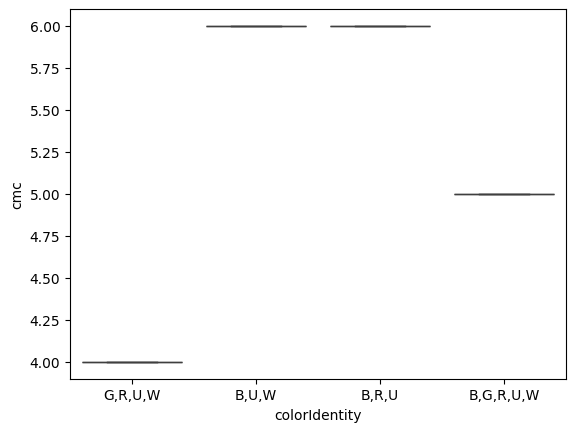

In [135]:
# Copy data frame for plotting
plot_df = formatted_data.copy()

# keep only rows where colorIdentity is more than 2 colors
plot_df = plot_df[plot_df['colorIdentity'].apply(lambda x: isinstance(x, list) and len(x) > 2)]

# convert lists to string (e.g. ['G', 'W', 'U] -> 'G,W,U')
plot_df['colorIdentity'] = plot_df['colorIdentity'].apply(lambda x: ",".join(x) if isinstance(x, list) else str(x))

# Plot graph
sns.boxplot(data=plot_df, x='colorIdentity', y='cmc')
plt.show()

In [147]:
plot_df = formatted_data.copy()
# keep only rows where types is a list and not equal to ['Land']
plot_df = plot_df[plot_df['types'].apply(lambda x: isinstance(x, list) and x != ['Land'])]
# Counts of each Color Identity
plot_df['colorIdentity'].value_counts().to_frame()

,count
colorIdentity,
[W],42
[B],42
[R],42
[G],41
[U],40
Colorless,19
"[G, W]",6
"[B, R]",6
"[B, W]",5


### CMC vs Rarity

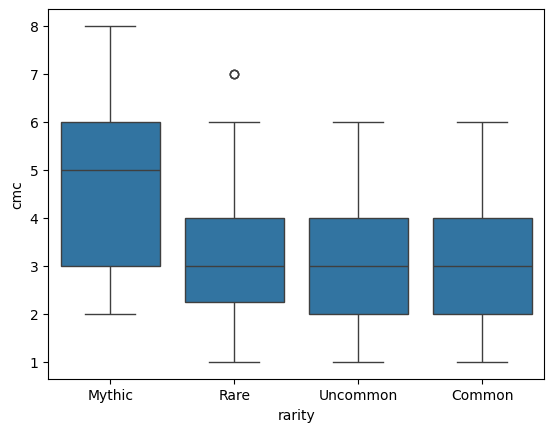

In [137]:
# Plot Rairity vs CMC
sns.boxplot(data = plot_df, x = 'rarity', y = 'cmc')

# Save Graph
plt.savefig('cmc_vs_rarity.png', bbox_inches='tight')
plt.show()

In [138]:
# Counts for each rarity
plot_df['rarity'].value_counts().to_frame()

,count
rarity,
Common,101
Uncommon,79
Rare,74
Mythic,21


### CMC vs Card Type

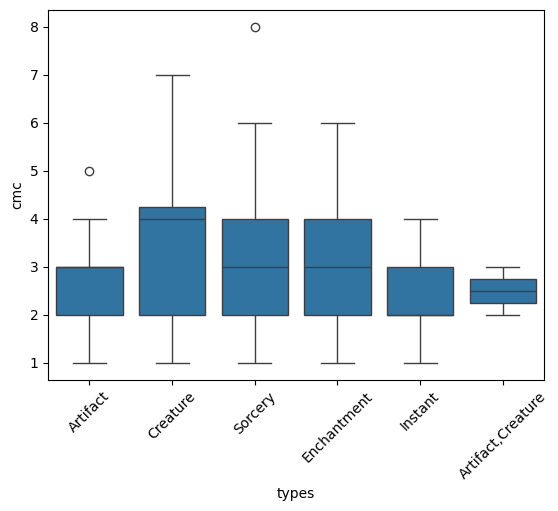

In [139]:
plot_df = formatted_data.copy()
# keep only rows where type is not a LAnd
plot_df = plot_df[plot_df['types'].apply(lambda x: isinstance(x, list) and x != ['Land'])]

# convert lists to string of type
plot_df['types'] = plot_df['types'].apply(lambda x: ",".join(x) if isinstance(x, list) else str(x))


sns.boxplot(data=plot_df, x='types', y='cmc')
plt.xticks(rotation = 45)

# Save Graph
plt.savefig('cmc_vs_card_type.png', bbox_inches='tight')
plt.show()

In [140]:
# Counts for each type
formatted_data['types'].value_counts()

types
[Creature]              148
[Instant]                38
[Sorcery]                36
[Enchantment]            28
[Artifact]               23
[Land]                   14
[Artifact, Creature]      2
Name: count, dtype: int64

## Distribution of Card Attributes

### Prevelence of Card Subtypes

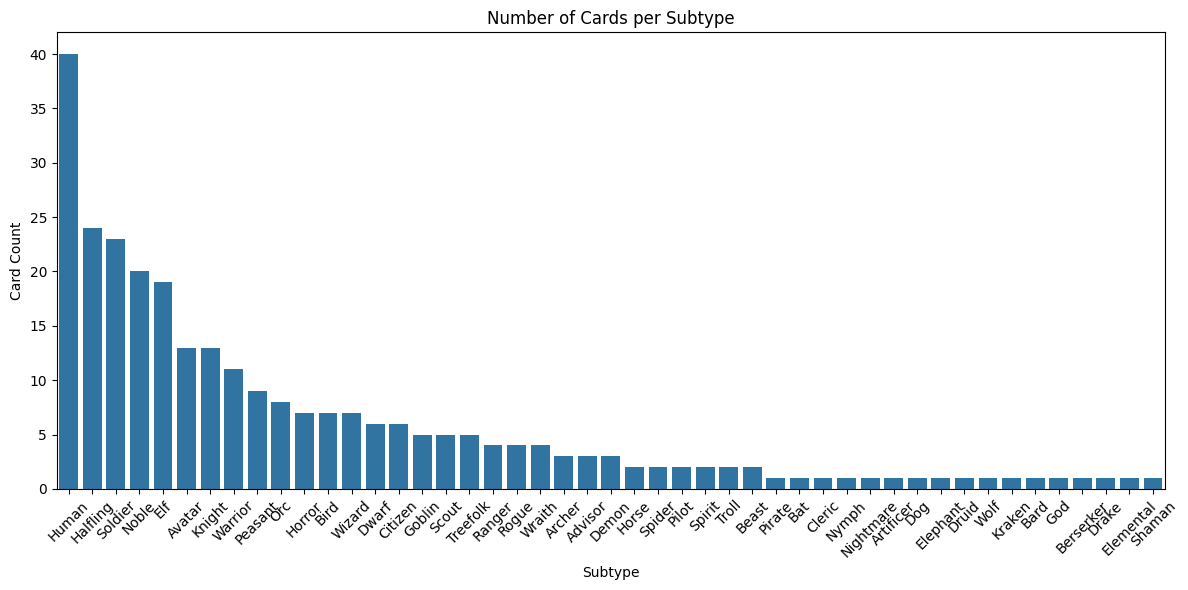

In [141]:
plot_df = formatted_data.copy()

# Filter to only cards that are creatures
plot_df = plot_df[plot_df['types'].apply(lambda x: isinstance(x, list) and (x == ['Creature'] or x == ['Artifact, Creature']) )]
plot_df['subtypes'] = plot_df['subtypes'].apply(lambda x: x if isinstance(x, list) else [])

# Explode the list into multiple rows
plot_df = plot_df.explode('subtypes').reset_index(drop=True)

# Get counts for each subtype
subtype_counts = plot_df['subtypes'].value_counts().reset_index()
subtype_counts.columns = ['subtype', 'count']

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=subtype_counts, x='subtype', y='count')
plt.xticks(rotation=45)
plt.title('Number of Cards per Subtype')
plt.ylabel('Card Count')
plt.xlabel('Subtype')
plt.tight_layout()

# Save Graph
plt.savefig('subtype.png', bbox_inches='tight')
plt.show()


### Distribution of Card Type by Color

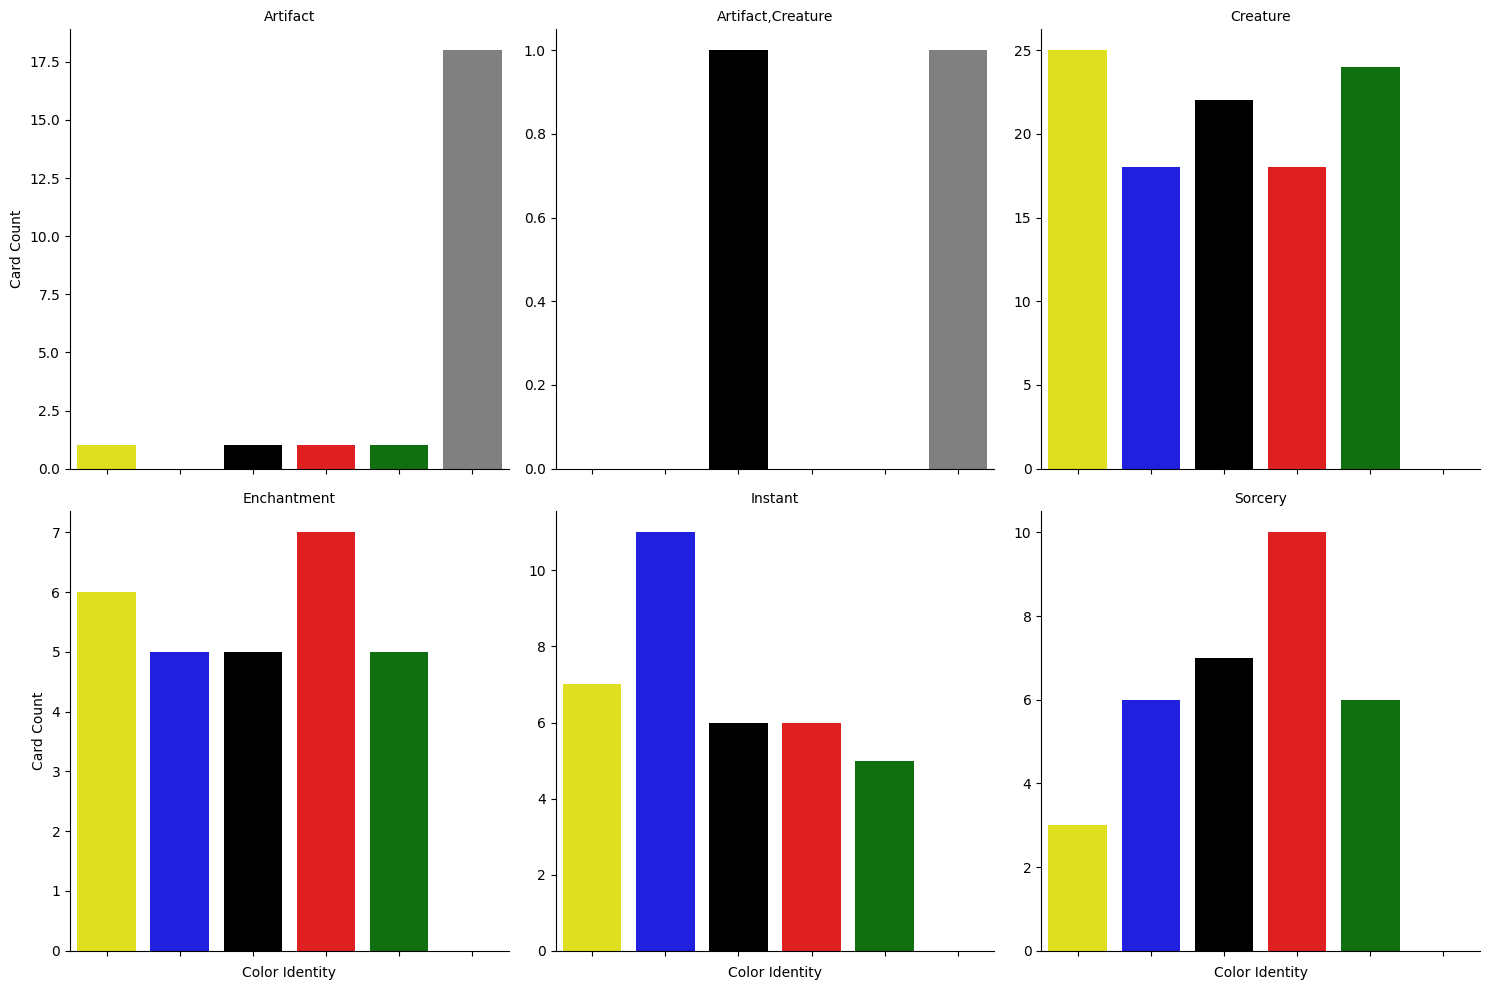

In [142]:
plot_df = formatted_data.copy()

# keep only rows where colorIdentity one color or colorless
plot_df = plot_df[plot_df['colorIdentity'].apply(lambda x: (isinstance(x, list) and len(x) <= 1) or x == 'Colorless')]

# convert single-element lists to the element (e.g. ['W'] -> 'W')
plot_df['colorIdentity'] = plot_df['colorIdentity'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Filter to only non Lands
plot_df = plot_df[plot_df['types'].apply(lambda x: isinstance(x, list) and x != ['Land'])]
plot_df['types'] = plot_df['types'].apply(lambda x: ",".join(x) if isinstance(x, list) else str(x))

# group by types and colorIdentity and count occurrences
subtype_counts = plot_df.groupby(['types', 'colorIdentity']).size().reset_index(name='count')

# Define WUBRG and Colorless order and custom colors
order = ['W', 'U', 'B', 'R', 'G', 'Colorless']
colors = ['yellow', 'blue', 'black', 'red', 'green', 'gray']
palette = dict(zip(order, colors))

# Facet wrap by 'types'
g = sns.catplot(
    data=subtype_counts,
    x='colorIdentity',
    y='count',
    col='types',            
    kind='bar',
    hue='colorIdentity',
    hue_order=order,
    order = order,
    palette=palette,
    col_wrap=3,             
    sharey=False            
)


# Rotate x-ticks and adjust titles
g.set_xticklabels(rotation=45)
g.set_titles("{col_name}")
g.set_axis_labels("Color Identity", "Card Count")
plt.tight_layout()

# Save Graph
plt.savefig('card_type_color.png', bbox_inches='tight')
plt.show()


### Distribution of Power and Toughness by Color

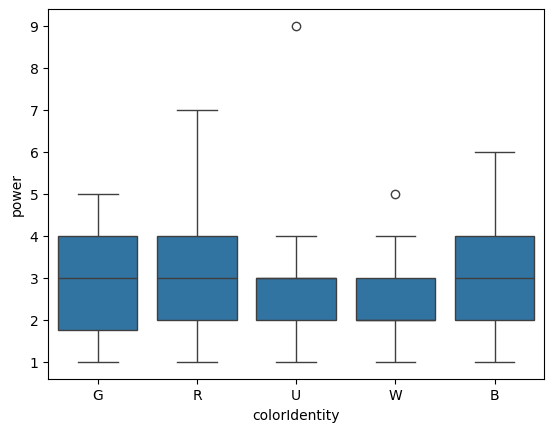

In [143]:
plot_df = formatted_data.copy()

# Filter to only creatures
plot_df = plot_df[plot_df['types'].apply(lambda x: isinstance(x, list) and x == ['Creature'])]

# Filter to only cards with one color
plot_df = plot_df[plot_df['colorIdentity'].apply(lambda x: isinstance(x, list) and len(x) <= 1)]

# Filter to only numberical powers(not *)
plot_df = plot_df[plot_df['power'].apply(lambda x: isinstance(x, str) and x.isdigit())]
plot_df['power'] = plot_df['power'].astype(int)

# convert lists to string (e.g. ['G', 'W'] -> 'G,W')
plot_df['colorIdentity'] = plot_df['colorIdentity'].apply(lambda x: ",".join(x) if isinstance(x, list) else str(x))

# Plot
sns.boxplot(data=plot_df, x='colorIdentity', y='power')

# Save Graph
plt.savefig('power_by_color.png', bbox_inches='tight')
plt.show()

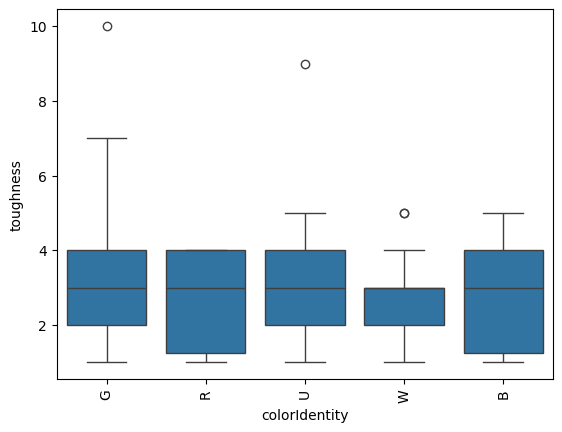

In [144]:
plot_df = formatted_data.copy()

# Filter to only creatures
plot_df = plot_df[plot_df['types'].apply(lambda x: isinstance(x, list) and x == ['Creature'])]

# Filter to only cards with  one color
plot_df = plot_df[plot_df['colorIdentity'].apply(lambda x: isinstance(x, list) and len(x) <= 1)]

# Filter to only numberical toughness(not *)
plot_df = plot_df[plot_df['toughness'].apply(lambda x: isinstance(x, str) and x.isdigit())]
plot_df['toughness'] = plot_df['toughness'].astype(int)

# convert lists to string (e.g. ['G', 'W'] -> 'G,W')
plot_df['colorIdentity'] = plot_df['colorIdentity'].apply(lambda x: ",".join(x) if isinstance(x, list) else str(x))


sns.boxplot(data=plot_df, x='colorIdentity', y='toughness')
plt.xticks(rotation = 90)

#Save Graph
plt.savefig('tough_by_color.png', bbox_inches='tight')
plt.show()

### Distribution of Supertypes

In [145]:
# Counts for supertypes
formatted_data['supertypes'].fillna('None').value_counts()

supertypes
None           175
[Legendary]    109
[Basic]          5
Name: count, dtype: int64

## Saving Data

In [146]:
formatted_data.to_csv("MTG_data")